# waves

In [21]:
#import math
from scipy import io
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import scipy.integrate
import pandas as pd
from IPython.display import display
import time
import matplotlib.colors as colors
import random
import glob
import os

**main variables**
<br> f - main frequency (Hz)
<br> full_f - the entire time-frequency function (Hz) ("x" as x axis)
<br> frangemax - x axis length of Fourier-transform, note, that this does not affect Fourier calculation
<br> samples - sample points of the first graph
<br> s_rate - sample rate (Hz)
<br> <br> First, we load our signal.

In [75]:
#%%script false
#path ='C:\\Users\\Marci\\Documents\\transientwaves\\imputdata\\in\\'#pc
path ='C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\in\\'#laptop

for filename in glob.glob(os.path.join(path, '*.sav')):
    sav1 = io.readsav(filename, python_dict = True)
    print('Loaded: '+filename)
    print('\n')

Loaded: C:\Users\win10\Downloads\transient-waves\inputdata\in\AUGD_32326_085-095_RFL.sav




In [76]:
#%%script false
shot_i=1
print(sav1)
s=np.array(sav1['data'][shot_i])#
x=np.array(sav1['timeax'])
print("\n", sav1['channels'])
print("\n", s)
#print("\n", sav1['channels'][shot_i])
sxr_name=str(sav1['channels'][shot_i])[2:4]+'R'+str(sav1['channels'][shot_i])[5:-1]
shot=os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+', '+str(sav1['channels'][shot_i])[2:-1]#sxr_name#
print("\n",shot)

{'expname': b'AUGD', 'shotnumber': 32326, 'channels': array([b'RFL-FLQ-I', b'RFL-FLQ-Q', b'RFL-FLV-I', b'RFL-FLV-Q',
       b'RFL-K-LFS', b'RFL-Ka-LFS', b'RFL-Q-LFS', b'RFL-V-LFS',
       b'RFL-K-HFS', b'RFL-Ka-HFS', b'RFL-Q-HFS', b'RFL-V-HFS'],
      dtype=object), 'data': array([[-0.0262439 , -0.01159457, -0.01403612, ..., -0.0653088 ,
        -0.07263347, -0.07385425],
       [-0.11536069, -0.10803603, -0.13367237, ..., -0.28016573,
        -0.28871116, -0.27772418],
       [-0.26307485, -0.2703995 , -0.27162027, ..., -0.28016573,
        -0.27406183, -0.26917872],
       ...,
       [-0.07873736, -0.07873736, -0.07263347, ...,  0.30214536,
         0.2838337 ,  0.26063892],
       [-0.41811365, -0.40590584, -0.35463318, ...,  0.15565202,
         0.21424936,  0.25819737],
       [-0.00304912,  0.00183399,  0.0067171 , ...,  0.01160021,
         0.01648333,  0.02258722]], dtype=float32), 'timeax': array([0.85     , 0.8500005, 0.850001 , ..., 0.949999 , 0.9499995,
       0.95     ]),

In [77]:
#%%script false
s = s.astype(float)
x = x.astype(float)
samples=s.size
#full_f = np.zeros(samples)
t=max(x)-min(x)
nyquist=samples/2/t
frangemax=nyquist#250000#
xf=np.linspace(0.0, frangemax, frangemax*t+1)
s_rate=x.size/t
print(nyquist)
print(x.size)

usewidgets=0
import ipywidgets as widgets
view=widgets.FloatSlider()
if usewidgets==1:
    display(view)
else:
    view.value=0

1000005.0000000002
200001


C:\Users\win10\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


The widget below controls the wisible range of the chart under it. Note that this is only for visualisation, the program calculates with the whole 0 - t range. The zooming is exponential. Value 0 displays the whole range.

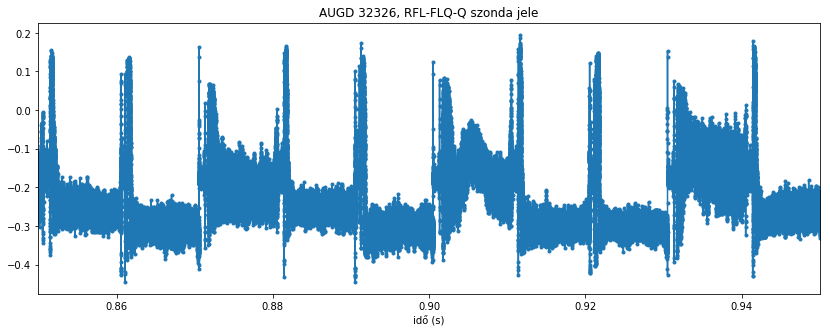


 AUGD 32326, RFL-FLQ-Q


In [78]:
#%%script false
plt.figure(figsize=(14,5))
plt.title(shot+' szonda jele')
plt.plot(x,s,'.-')
#yaxismax=1/2**(view.value/12)
plt.xlim(min(x),max(x)-(max(x)-min(x))*((view.value/100.4)**0.6))
#plt.ylabel('radiális mágneses tér változás (T/s)')
plt.xlabel('idő (s)')
#plt.savefig(shot+' in.pdf')
plt.show()

print("\n",shot)

**RFL jelek minősége**
AUGD 32326, 0.85-0.95 s
<br>

 - no3 lassú, 
 - no4 zavart, de kicsiben jó
 - **no8 egész jó, 1ms sweep
 - **no9 1ms sweep
 - no10 zavart, de látható sweep
 - no11 ????, de nem zavart kicsiben
 - no12 

The script provided at   *augtwiki/bin/view/Reflectometry/Read*   to load reflectometries

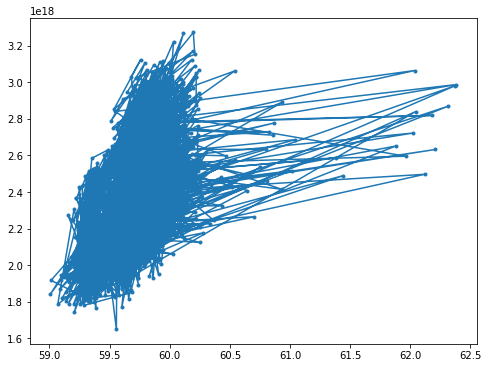

In [71]:
#%%script false
#import dd
#import matplotlib.pylab as plt

##Open the shotfile
#rps = dd.shotfile('RPS', 30554)

##Read the data
nl = np.array(sav1['data'][shot_i+000]) #rps('neb_LFS')
rl = np.array(sav1['data'][shot_i+100]) #rps('RB_LFS')
#nh = rps('neb_HFS')
#rh = rps('RB_HFS')
#time = rps('TIME')

#Close the shotfile rps.close()
# Get the times time = rps('TIME')

plt.figure(figsize=(8,6))
plt.plot(rl,nl,'.-')#.data[1000,:]
#plt.title('%s @ t=%3.2fs'%(nl.description, time[1000]))
#plt.ylabel(nl.unit)
#plt.xlabel('R [%s]' %(rl.units))
plt.show()

### Trigger and cutting

In [ ]:
s_cut= np.zeros((int(samples/d_win+0.9), hann_r*2+1))


In [74]:
print(sav1['data'].shape)
s_cut= np.zeros((sav1['data'].shape))
#print(s_cut.shape[0])

#for i in range(int(s_cut.shape[0]/3)):
#    print("i")

(300, 8000)
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i
i


## Short-time Fourier transform

5.781813074949742e-06
3388029.9451573994
450


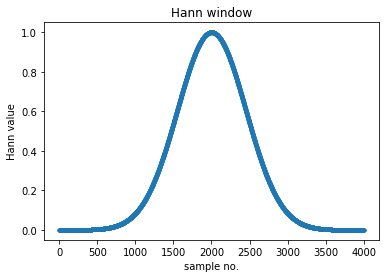

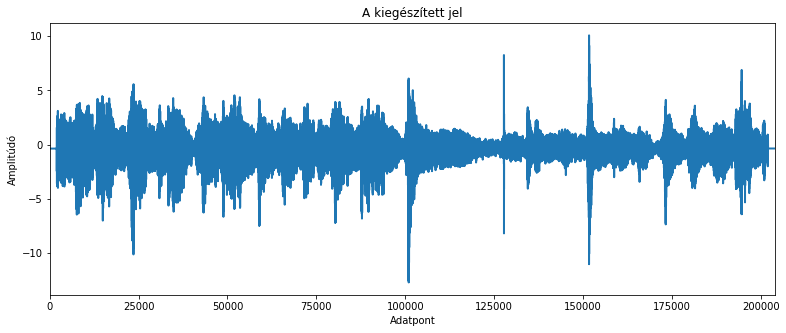

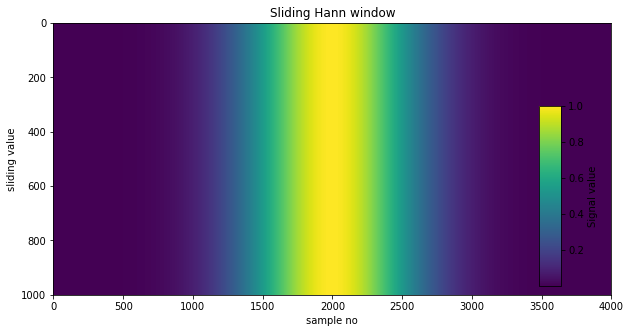

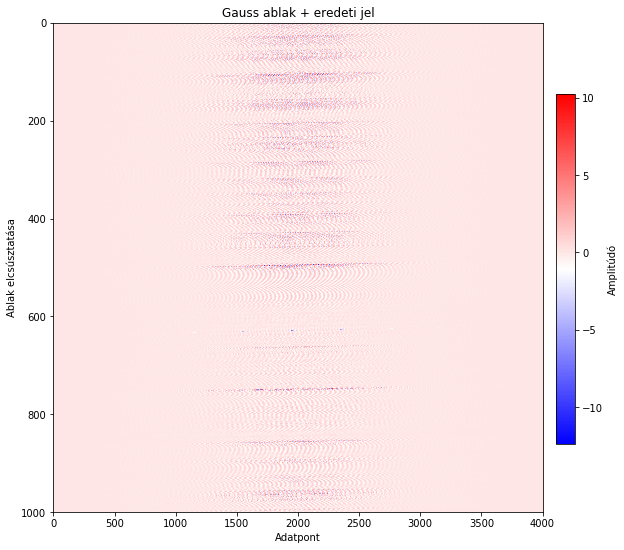

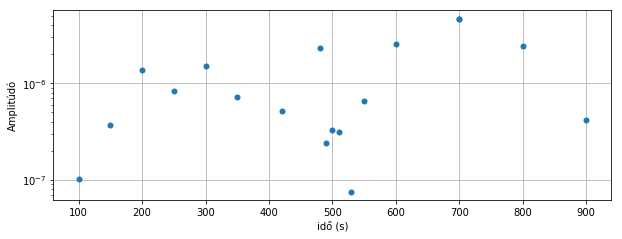

In [11]:
t0=time.time()
hann_r = 2000 #1000
d_win=200#random.randint(200,300)
std=450 #150
win_base = scipy.signal.gaussian(2*hann_r+1, std=std)#np.hanning(2*hann_r+1)

plt.plot(win_base,".-")
plt.title('Hann window')
plt.xlabel('sample no.')
plt.ylabel('Hann value')
#plt.show()

z_padded_s = np.zeros (samples+2*hann_r)
z_0=z_padded_s
z_padded_s[hann_r:-hann_r] = s
z_padded_s[0:hann_r]=np.average(z_padded_s[hann_r+1:2*hann_r])
z_padded_s[-hann_r:]=np.average(z_padded_s[-2*hann_r:-hann_r-1])
x_hann=np.linspace(0.0, t+(2*hann_r/s_rate), samples+2*hann_r)

plt.figure(figsize=(13,5))
plt.plot(z_padded_s,"-",linewidth = 2)#x_hann,idő (s),max(x_hann)
plt.xlim((0,samples+2*hann_r))
plt.title('A kiegészített jel')
plt.xlabel('Adatpont')
plt.ylabel('Amplitúdó')
plt.savefig('sxr2_p.pdf')
#plt.show()

win = np.zeros((int(samples/d_win+1), 2*hann_r+1))
for i in range(int(samples/d_win+1)):
    win [i]=win_base

plt.figure(figsize=(10,5))
plt.imshow(win,aspect='auto')
plt.title('Sliding Hann window')
plt.xlabel('sample no')
plt.ylabel('sliding value')
#plt.subplots_adjust(right=0.95)
cax = plt.axes([0.8, 0.15, 0.03, 0.5])
plt.colorbar(cax=cax).set_label('Signal value')
#plt.show()

z_win = np.zeros((int(samples/d_win+0.9), hann_r*2+1))
for i in range(int(samples/d_win+0.9)):
    z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+hann_r+hann_r+1]-np.average(z_padded_s [d_win*i:d_win*i+hann_r+hann_r+1]))
    #z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+hann_r+hann_r+1])

plt.figure(figsize=(9,9))
plt.imshow(z_win,aspect='auto',cmap='bwr')#, extent=(min(x)*s_rate/d_win,max(x)*s_rate/d_win,max(x)*s_rate,min(x)*s_rate)
plt.title('Gauss ablak + eredeti jel')
plt.xlabel('Adatpont')
plt.ylabel('Ablak elcsúsztatása')
plt.subplots_adjust(right=0.88)
cax = plt.axes([0.90, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig('z_win.pdf')
#plt.show()

z_win_fft = np.zeros((int(samples/d_win+0.9), hann_r*2+1))
for i in range(int(samples/d_win+0.9)):
    z_win_fft[i] = np.abs(scipy.fftpack.fft(z_win[i]))  
t1=time.time()



print(z_win_fft.min()**2)
print(z_win_fft.max()**2)
print(std)

stft_mins=[1.01695e-07,3.673117652986607e-07,1.38345e-06,8.39383910e-07,7.18778343e-07,
           3.2706793e-07,2.588379900248037e-06,4.686041924024207e-06,2.41798e-06,
           4.1317346e-07,5.222443153781323e-07,7.537558838312127e-08,6.549159109489878e-07,1.5261556529458865e-06,
           4.686041924024207e-06,2.3985409915804117e-07,2.306638467597165e-06,3.1665114531379547e-07]
stft_maxs=[619967,1136464,1632555,2095193,2860321,3617474,4114971,4507952,4815466,5056280,3237772,3778642,3880313,2517276,
           4507952,3561414,3521555,3672362]
win_stds=[100,150,200,250,350,500,600,700,800,900,420,530,550,301,700,490,480,510]

plt.figure(figsize=(10,3.5))
#plt.title('Az amplitúdó a maximum frekvenciaértékeknél, '+shot)#, AUGD 34924 J051-es szonda
plt.plot(win_stds,stft_mins,'.',markersize=10)#,x,3*abs(np.sin(2*np.pi*x))+2,
plt.grid(True)
plt.ylabel('Amplitúdó')
plt.xlabel('idő (s)')
plt.yscale("log")
#plt.savefig(shot+'_amp.pdf')
plt.show()

In [12]:
%%script false
print(win_base[0])
print(z_win[45])
plt.figure(figsize=(4,4))
plt.plot(z_win[1258], linewidth = 0.5)#l
plt.title('Gauss ablak+ eredeti je')
plt.xlabel('Adatpont')
plt.ylabel('Amplitúdó')
#plt.savefig('sxr2_1000.pdf')
plt.show()

Couldn't find program: 'false'


In [13]:
%%script false
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Axes3D.plot_surface(z_win[:,0],z_win[:,1],z_win[:,2])
plt.show()

Couldn't find program: 'false'


In [14]:
%%script false
t2=time.time()
f_ax_stft, t_ax_stft, z_spy_stft = scipy.signal.stft(s,s_rate,window=win_base, nperseg=hann_r*2+1, noverlap =hann_r*2+1-d_win)
t3=time.time()
print(t1-t0)
print(t3-t2)

Couldn't find program: 'false'


In [15]:
%%script false
z_spy_stft=np.abs(z_spy_stft)**2
z_spy_stft_cutted = np.zeros((int(frangemax*(2*hann_r+1)/s_rate),int(samples/d_win)))#int(frangemax*t+0.01)
for i in range(int(samples/d_win)):
    for j in range(int(frangemax*(2*hann_r+1)/s_rate)):
        z_spy_stft_cutted [j][i] = z_spy_stft [j][i]

Couldn't find program: 'false'


In [16]:
z_win_fft_cutted = np.zeros((int(frangemax*(2*hann_r+1)/s_rate), int(samples/d_win)))
for i in range(int(samples/d_win)):
    for j in range(int(frangemax*(2*hann_r+1)/s_rate)): #int(frangemax*max(x_hann))
        z_win_fft_cutted [j][i] = z_win_fft [i][j]**2

#print(z_spy_stft.shape)
#print(z_spy_stft_cutted.shape)
print(z_win_fft.shape)
print(z_win_fft_cutted.shape)
#print(z_win_fft.max()/abs(z_spy_stft.max()))

(1000, 4001)
(2000, 1000)


NameError: name 'z_spy_stft' is not defined

In [ ]:
%%script false
file2 = open("stft.txt","a")
for i in range(int(samples/d_win/37.5)):#
    for j in range(int(50000*(2*hann_r+1)/s_rate)):
        j2=int(55000*(2*hann_r+1)/s_rate)
        i2=int(samples/d_win/3+samples/d_win/30)
        file2.write(str(i/10)+"\t"+str(j/10)+"\t"+str(np.log10(z_spy_stft [j+j2][i*10+i2])+3)+"\n")#
print(i,j)

In [ ]:
%%script false
file2.close()

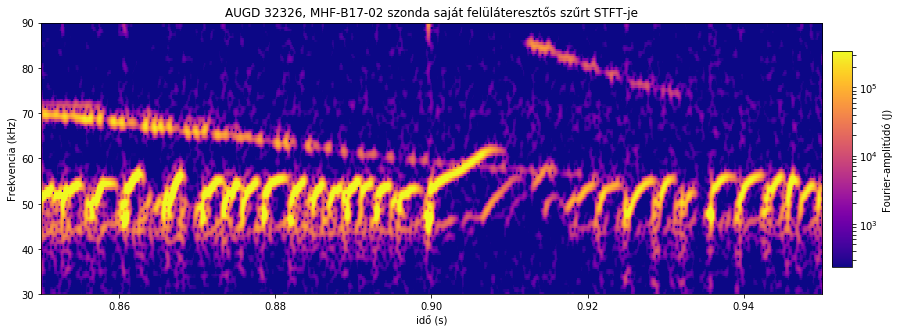

In [17]:
##### %%script false
colornorm=colors.LogNorm(vmin=z_win_fft_cutted.min()*40000000, vmax=z_win_fft_cutted.max()/10)
logax = np.linspace(int(np.log10(z_win_fft_cutted.min())),int(np.log10(z_win_fft_cutted.max())),int(np.log10(z_win_fft_cutted.max()))-int(np.log10(z_win_fft_cutted.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(14,5))
#extent=[0,t-(2*hann_r/s_rate),0,frangemax/t],
#plt.figure(figsize=(15,10))
#ax.plot(x,np.abs(full_f),color='g',linewidth=3,linestyle='dashed',alpha=0.6)#img = ax.
img = plt.imshow(z_win_fft_cutted,cmap='plasma',  aspect='auto', extent=[min(x),max(x),frangemax/1000,0], norm=colornorm)#interpolation='gaussian',*30000000/4
#plt.title('39424-es kisülés, J051-es szonda STFT-je')
plt.title(shot+' szonda saját felüláteresztős szűrt STFT-je')
#plt.title('AUGD 34924, B31-40-es szonda STFT-je')
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')#('time (s)')
#plt.xlim(0.642,0.658)
plt.ylim(90,30)
plt.subplots_adjust(right=0.90)
plt.gca().invert_yaxis()
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier-amplitúdó (J)')
#plt.axis([2.13,2.15,min(s),20000])
#cbar.set_ticks(logax)
plt.savefig(shot+' stft.pdf')#34924_40
plt.show()

In [1002]:
%%script false
logax = np.linspace(int(np.log10(z_spy_stft_cutted.min())),int(np.log10(z_spy_stft_cutted.max())),int(np.log10(z_spy_stft_cutted.max()))-int(np.log10(z_spy_stft_cutted.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(10,5))
#plt.figure(figsize=(15,10))
#plt.pcolormesh(f_ax, t_ax, np.abs(z_spy_stft), vmin=0, vmax=amp) # extent=[min(x),max(x),frangemax,0],
#ax.plot(x,np.abs(full_f),color='w',linewidth=3,linestyle='dashed')
plt.title('teszt jel szűretlen könyvtári STFT-je')
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')
#plt.ylim(140,0)
plt.subplots_adjust(right=0.90)
img2 = ax.imshow(np.abs(z_spy_stft_cutted),cmap='plasma', interpolation='gaussian', aspect='auto',extent=[min(x),max(x),frangemax/1000,0], norm=colors.LogNorm(vmin=z_spy_stft_cutted.min()*1, vmax=z_spy_stft_cutted.max()/2))#)*4000000/800
plt.gca().invert_yaxis() #extent=[min(x),max(x),frangemax,0],
cbar=plt.colorbar(img2,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier value')
#cbar.set_ticks(logax)
plt.savefig('t_stft1.pdf')
plt.show()

print(np.max(z_spy_stft))

Couldn't find program: 'false'


1000.005
2000009.1000000006
-1113591.921667387
47.54914706678143


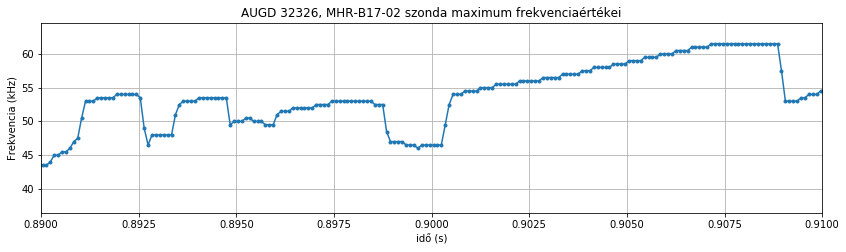

(1001, 2001)
(1000,)


In [1003]:
#%%script false
#ridge_no = 1
print(samples/d_win)

print(s_rate-0.9)
print(nyquist/((2*hann_r+1)/s_rate-0.9))
ridge_d=20000#50#
ridge_d2=8000
ridge_start=40000#2#
ridge = np.zeros(int(samples/d_win+0.9))
ridge_h = np.zeros(int(samples/d_win+0.9))
maxi=z_win_fft.max()/40
print(maxi)

for i in range(int(samples/d_win+0.9)):
    ridgeval=0  #max(z_spy_stft[i][:])
    if (i==0) or (ridge[i-1]==0):
        for j in range(int(ridge_d*(2*hann_r+1)/(s_rate-0.9))):
            j2=j+int((ridge_start)*(2*hann_r+1)/(s_rate-0.9))
            if ridgeval < z_win_fft[i][j2]:
                ridgeval=z_win_fft[i][j2]
                ridge[i]= j2
    else:
        for j in range(int(ridge_d2*(2*hann_r+1)/(s_rate-0.9))):
            j2=int(j+ridge[i-1]-(ridge_d2/2)*(2*hann_r+1)/(s_rate-0.9))
            if ridgeval < z_win_fft[i][j2]:
                ridgeval=z_win_fft[i][j2]
                ridge[i]= j2
                #print(j2, z_spy_stft[j2][i])
    if ridgeval<(maxi):
        ridgeval =0
        ridge [i]=0
    ridge_h[i]=ridgeval**(1/2)
    #print(i, ridge [i])
    #print (i,"  ",ridge[i],"\t", ridgeval,"\t", z_spy_stft[i][int(ridge[i])])

ridge=ridge*(s_rate/(2*hann_r+1))

#proc_x=np.linspace(min(x),max(x),np.size(ridge))
ridge[ ridge==0 ] = np.nan
plt.figure(figsize=(14,3.5))
plt.title(shot+' szonda maximum frekvenciaértékei')
plt.plot(np.linspace(min(x),max(x),np.size(ridge)),ridge/1000,'.-',x,full_f/1000)
plt.grid(True)
#plt.legend(('Kiszámolt', 'Eredeti'))
#yaxismax=1/2**(view.value/12)
plt.xlim(min(x),max(x))
plt.ylim(ridge_start/1100,)
#plt.ylim(0,200)
plt.xlim(0.89,0.91)
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')
plt.savefig(shot+' f_max.pdf')
plt.show()
print(z_spy_stft.shape)
print(ridge.shape)

In [1004]:
%%script false
plt.figure(figsize=(14,3.5))
x_ridge=np.linspace(min(x),max(x),np.size(ridge))
diff_ridge=(f-60/((x_ridge/1.5)+1.8))*7-30-ridge#15+10*np.sin(np.pi*x_ridge)
plt.plot(x_ridge,abs(diff_ridge))#/ridge
plt.ylabel('Frekvencia (Hz)')
plt.xlabel('idő (s)')
plt.grid(True)
plt.xlim(min(x),max(x))
#plt.ylim(0,4)
plt.savefig('t_diff.pdf')
plt.show()
#((1/(np.size(ridge)-1))*sum((diff_ridge/ridge)**2))**(1/2)
np.average(abs(diff_ridge))

Couldn't find program: 'false'


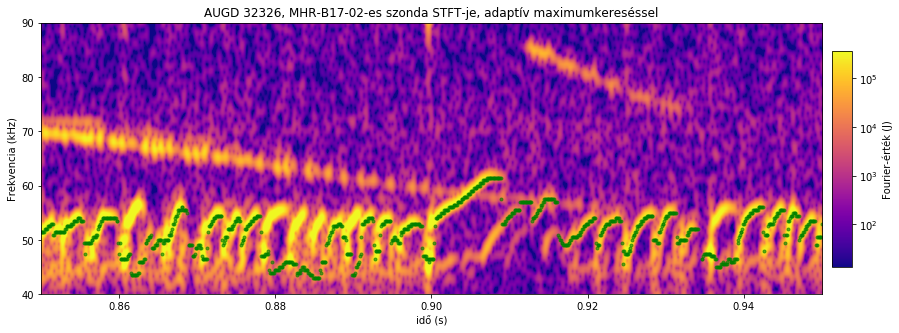

In [1005]:
logax = np.linspace(int(np.log10(z_win_fft_cutted.min())),int(np.log10(z_win_fft_cutted.max())),int(np.log10(z_win_fft_cutted.max()))-int(np.log10(z_win_fft_cutted.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(14,5))
#extent=[0,t-(2*hann_r/s_rate),0,frangemax/t],
#plt.figure(figsize=(15,10))
ax.plot(np.linspace(min(x),max(x),np.size(ridge)),ridge/1000,'.',color='g',alpha=0.6)#,linewidth=3,linestyle='dashed')#img = ax.
img = plt.imshow(z_win_fft_cutted,cmap='plasma', interpolation='gaussian', aspect='auto', extent=[min(x),max(x),frangemax/1000,0], norm=colornorm)#
#plt.title('My Short-time Fourier transform')
plt.title(shot+'-es szonda STFT-je, adaptív maximumkereséssel')
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')#('time (s)')
#plt.xlim(0.652,0.66)
plt.ylim(90,40)
plt.subplots_adjust(right=0.90)
plt.gca().invert_yaxis()
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier-érték (J)')
#plt.axis([2.13,2.15,min(s),20000])
cbar.set_ticks(logax)
plt.savefig(shot+' stft_max.pdf')
plt.show()

5.162487458321679


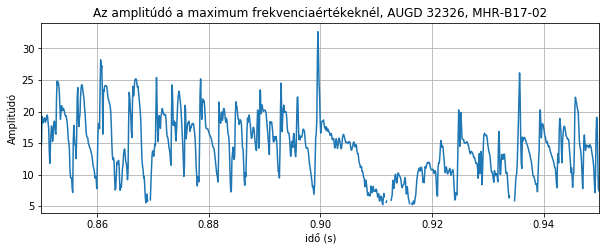

(1001, 2001)
(1000,)


In [968]:
ridge_h[ ridge_h==0 ] = np.nan
print(maxi**(1/2))
plt.figure(figsize=(10,3.5))
plt.title('Az amplitúdó a maximum frekvenciaértékeknél, '+shot)#, AUGD 34924 J051-es szonda
plt.plot(np.linspace(min(x),max(x),np.size(ridge_h)),ridge_h,'-',markersize=1)#,x,3*abs(np.sin(2*np.pi*x))+2,
plt.grid(True)
plt.xlim(min(x),max(x))
#plt.xlim(0.89,0.91)
#plt.ylim(maxi**(1/2)/2,max(ridge_h)*1.05)
plt.ylabel('Amplitúdó')
plt.xlabel('idő (s)')
#plt.yscale("log")
plt.savefig(shot+'_amp.pdf')
plt.show()
print(z_spy_stft.shape)
print(ridge.shape)

amp_diff=np.zeros(int(samples/d_win+0.9))#
for i in range(int(samples/d_win+0.9)):
    amp_diff[i]=np.sqrt(ridge_h[i])-3*abs(np.sin(2*np.pi*x[20*i]))

## Small observations
Now, we make histograms of the noise and the entire signal. The difference - if the input is a single frequency - only one point. In general: it is the signal. We will fit a half gaussian onto these, and see, how likely it is, that the difference (signal) is produced by the noise.

In [353]:
%%script false
hist_bins = np.linspace(0, 50000, 50)

"""plt.figure(figsize=(13,5))
plt.hist(yf_noise,hist_bins, density=True)
plt.title('Distribution of Fourier transformation (non-deterministic component)')
plt.ylabel('Frequency (%)')
plt.xlabel('Fourier amplitude')
plt.grid(True)
plt.show()"""

plt.figure(figsize=(13,5))
plt.hist(yfabs, hist_bins, density=True)
plt.title('Distribution of entire Fourier transformation')
plt.ylabel('Frequency (%)')
plt.xlabel('Fourier amplitude')
plt.yscale('log')
plt.grid(True)
plt.show()

Couldn't find program: 'false'


In [354]:
%%script false
plt.figure(figsize=(13,5))
plt.acorr(yfabs, maxlags=1400)
plt.axis([-1,1400,0,1])
#plt.xlim((0,frangemax))
plt.xlabel('$\Delta$ frequency (Hz)')
plt.ylabel('Autocorrelation value')
#plt.xscale('log')
plt.title('Autocorrelation of fourier value')
plt.grid(True)
plt.show()

def acf(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

s_acf=acf(s)
s_acf=s_acf/np.max(s_acf)
s_acf_fft_abs=abs(scipy.fftpack.fft(s))
s_acf_fft_ang=np.angle(scipy.fftpack.fft(s))/np.pi

plt.figure(figsize=(13,5))
plt.plot(x,s_acf)
#plt.axis([0,frangemax,0,1.5/rs])
plt.xlim(min(x),max(x))
plt.xlabel('$\Delta$t (s)')
plt.ylabel('Autocorrelation value')
#plt.xscale('log')
plt.title('Autocorrelation of input signal')
plt.grid(True)
#plt.show()

plt.figure(figsize=(13,5))
plt.plot(xf,s_acf_fft_abs[:xf.size])
#plt.axis([0,frangemax,0,1.5/rs])
plt.xlim((0,frangemax))
plt.xlabel('frequency (Hz)')
plt.ylabel('Fourier value')
#plt.xscale('log')
plt.title("Autocorrelation's Fourier-transform's amplitude")
plt.grid(True)
#plt.show()

plt.figure(figsize=(13,5))
plt.plot(xf,s_acf_fft_ang[:xf.size])
#plt.axis([0,frangemax,0,1.5/rs])
plt.xlim((0,frangemax))
plt.xlabel('frequency (Hz)')
plt.ylabel('Fourier value')
#plt.xscale('log')
plt.title("Autocorrelation's Fourier-transform's phase")
plt.grid(True)
#plt.show()

Couldn't find program: 'false'


We can see, that the ratio of the values of the Fourier transform of the deterministic and non-deterministic components of the input signal is practically a constant, and it is influenced by the relative amplitude of these components in the original signal. Is this a coincidence? [drawing](https://i.redd.it/nnlrafulz5701.jpg)

In [355]:
%%script false
det_noise_fft_ratios = yfabs/np.abs(yf_noise[:xf.size]+yf_det[:xf.size])
print("Ratio of the ffts of deterministic and non-deterministic components:",'\naverage:',np.average(det_noise_fft_ratios))
print('Standard deviation:',np.std(det_noise_fft_ratios))
if 0<np.std(det_noise_fft_ratios)<0.001 :
    print("The deviation is practically zero.")

Couldn't find program: 'false'


The next cell is used to evaluate how fast our stft is. If we got enough data (what we have) we can plot it.

In [356]:
for q in range(100):
    q2=np.log(q+1)**2.5
    print(q2*q, q2)

0.0 0.0
0.4000033721822121 0.4000033721822121
2.5301200434093474 1.2650600217046737
6.788282327220686 2.2627607757402286
13.144545075930008 3.286136268982502
21.48667798308604 4.2973355966172075
31.69262473694979 5.282104122824965
43.6480483205639 6.235435474366271
57.25008127714405 7.156260159643006
72.40719627068192 8.04524403007577
89.03802719249103 8.903802719249104
107.07001927704587 9.73363811609508
126.43817918997576 10.53651493249798
147.0839938971791 11.314153376706086
168.95451927585324 12.068179948275231
192.0016186474618 12.800107909830787
216.1813273900632 13.51133296187895
241.45332146720008 14.203136556894123
267.7804709804837 14.876692832249095
295.1284632157288 15.533077011354148
323.46548261658506 16.173274130829252
352.76193757765435 16.798187503697825
382.9902259320097 17.408646633273168
414.12453258791925 18.005414460344316
446.14065402251276 18.5891939176047
479.01584533344055 19.160633813337622
512.7286863387035 19.720334089950132
547.2589638440074 20.26885051274

In [357]:
%%script false
file = open("out.txt","a")
for q in range(10000):
    f=40
    #t=4
    #q2=np.log(10*q+15)**3.3
    samples=int(100000+21*q+random.randint(0,20))
    s_rate=1000
    t=samples/s_rate
    randamp=5
    nyquist=samples/2/t
    frangemax=nyquist

    xf=np.linspace(0.0, frangemax, int(frangemax*t+1))
    x = np.linspace(0.0, t, samples)
    full_f=np.linspace(f, f, samples) #   f/2+np.sin(2*np.pi*x)   f+x*0.01        (f-65/(x+1.1))
    full_f_phase = np.zeros(samples)
    for i in range (samples):
        full_f_phase[i]=np.sum(full_f[:i])/500
    
    amp=1#0.4+x/t*0.6

    s_det = amp*np.sin(full_f_phase*np.pi) #Changing freqency. old way: *(1+(x*10**2)**0.5)
    s_noise = (np.random.rand(samples)-0.5)*randamp
    s=(s_det+s_noise)/(0.5*randamp+1)
       
    t0=time.time()
    hann_r = 120#5*q+3758+random.randint(0,4)#
    d_win=30#random.randint(200,300)
    hann_base = np.hanning(2*hann_r+1)

    z_padded_s = np.linspace (0, 0, samples+2*hann_r+1)
    z_0=z_padded_s
    z_padded_s[hann_r:-hann_r-1] = s
    x_hann=np.linspace(0.0, t+(2*hann_r/s_rate), samples+2*hann_r)

    win = np.zeros((int(samples/d_win+1), 2*hann_r+1))
    for i in range(int(samples/d_win+1)):
        win [i]=hann_base
    
    #print(str(hann_r*2+1)+"\t"+str(win.shape))
    
    z_win = np.zeros((int(samples/d_win+1), hann_r*2+1))
    for i in range(int(samples/d_win+1)):
        z_win[i] = win[i] * z_padded_s [d_win*i:d_win*i+hann_r+hann_r+1]

    z_win_fft = np.zeros((int(samples/d_win+1), hann_r*2+1))
    for i in range(int(samples/d_win+1)):
        z_win_fft[i] = np.abs(scipy.fftpack.fft(z_win[i]))  

    t1=time.time()
    
    t2=time.time()
    hann_big=np.zeros(samples)
    for i in range(2*hann_r):
        hann_big[int(samples/2-hann_r+i)] = hann_base[i]

    f_ax_stft, t_ax_stft, z_spy_stft = scipy.signal.stft(s,1000,window=hann_big, nperseg=samples, noverlap =samples-d_win)
    t3=time.time()
    
    if t1>t0 and t3>t2:
        file.write(str(t1-t0)+"\t"+str(t3-t2)+"\t"+str(samples)+"\t"+str((t1-t0)/(t3-t2))+"\n")
        print(str(q)+"\t"+ str(t1-t0)+"\t"+str(t3-t2)+"\t"+str(samples)+"\t"+str((t1-t0)/(t3-t2)))
file.close()

Couldn't find program: 'false'


In [358]:
%%script false
file.close()

Couldn't find program: 'false'


In [359]:
dsamples = pd.read_excel("stft_speed.xlsx", 0)
dHann_r = pd.read_excel("stft_speed.xlsx", 1)
dd_win = pd.read_excel("stft_speed.xlsx", 2)
dsignaltype = pd.read_excel("stft_speed.xlsx", 3)
print (dsamples.tail())
print (dHann_r.head())
print (dd_win.head())
print (dsignaltype.shape)

             my     scipy  samples     ratio  hann_r  d_win comment
10341  0.218791  8.905945    46439  0.024567     NaN    NaN     NaN
10342  0.203121  8.859166    46457  0.022928     NaN    NaN     NaN
10343  0.218743  8.817290    46487  0.024808     NaN    NaN     NaN
10344  0.203124  8.870936    46505  0.022898     NaN    NaN     NaN
10345  0.218743  8.842063    46539  0.024739     NaN    NaN     NaN
         my     scipy     ratio  hann_r  samples  d_win comment
0  0.561853  0.057053  9.847987      19  10000.0   30.0    40Hz
1  0.420790  0.057938  7.262776      29      NaN    NaN     NaN
2  0.366953  0.058168  6.308504      47      NaN    NaN     NaN
3  0.325504  0.056956  5.714984      50      NaN    NaN     NaN
4  0.306613  0.057956  5.290450      92      NaN    NaN     NaN
          my     scipy  d_win     ratio  hann_r  samples comment
0  13.509928  8.544886      1  1.581054   300.0  15000.0    40Hz
1   6.189550  2.748324      2  2.252118     NaN      NaN     NaN
2   4.150764 

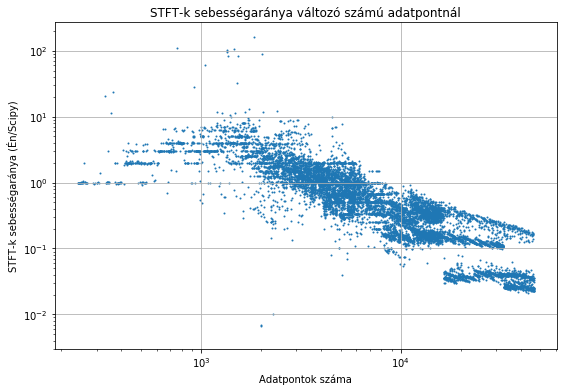

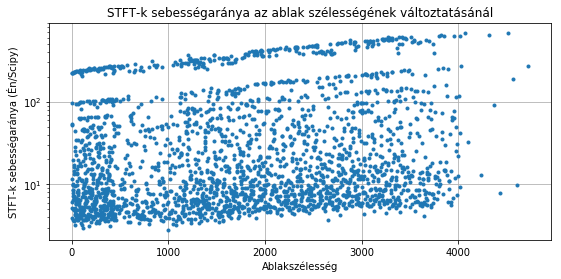

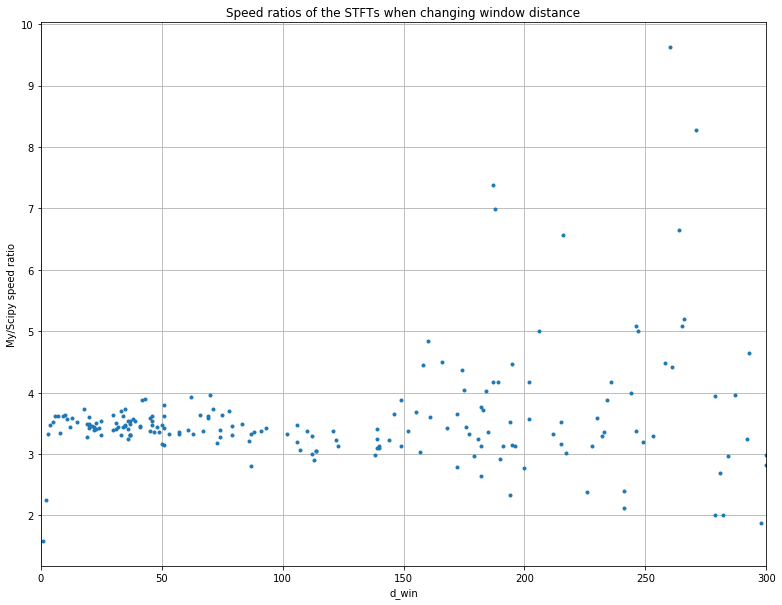

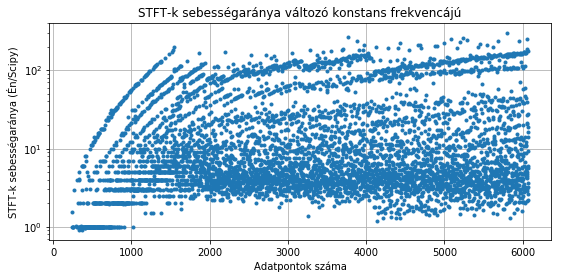

In [360]:
plt.figure(figsize=(9,6))
plt.scatter(dsamples.samples,dsamples.ratio,s=1)
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Adatpontok száma')
plt.ylabel('STFT-k sebességaránya (Én/Scipy)')
plt.title('STFT-k sebességaránya változó számú adatpontnál')
plt.savefig('speed_4.pdf')
#plt.xlim(0,7000)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(dHann_r.hann_r,dHann_r.ratio,'.')
plt.grid()
plt.yscale("log")
plt.xlabel('Ablakszélesség')
plt.ylabel('STFT-k sebességaránya (Én/Scipy)')
plt.title('STFT-k sebességaránya az ablak szélességének változtatásánál')
#plt.xlim(0,6000)
plt.savefig('speed_0.pdf')
plt.show()

plt.figure(figsize=(13,10))
plt.plot(dd_win.d_win,dd_win.ratio,'.')
plt.grid()
#plt.yscale("log")
plt.xlabel('d_win')
plt.ylabel('My/Scipy speed ratio')
plt.title('Speed ratios of the STFTs when changing window distance')
plt.xlim(0,300)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(dsignaltype.samples,dsignaltype.ratio,'.')
plt.grid()
plt.yscale("log")
plt.xlabel('Adatpontok száma')
plt.ylabel('STFT-k sebességaránya (Én/Scipy)')
plt.title('STFT-k sebességaránya változó konstans frekvencájú')
#plt.xlim(0,6000)
plt.savefig('speed_1.pdf')
plt.show()

In this cell, we create a plot for binding energies.

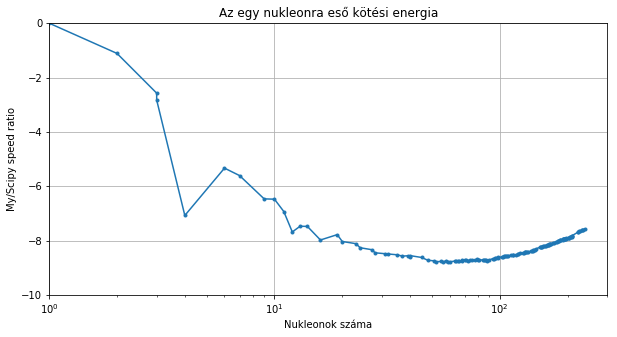

In [361]:
kotesi=pd.read_excel("kotesi.xlsx", 1)

plt.figure(figsize=(10,5))
plt.plot(kotesi.nuc,(-1)*kotesi.epn,'.-')
plt.grid()
plt.xscale("log")
plt.xlabel('Nukleonok száma')
plt.ylabel('My/Scipy speed ratio')
plt.title('Az egy nukleonra eső kötési energia')
plt.xlim(1,300)
plt.ylim(-10,0)
plt.show()

In [362]:
ch=np.loadtxt(open("output.txt", "rb"), delimiter=" ")
print(ch)
ch=ch.T

[[1.88840000e-12 2.22800000e-12 2.70680000e-12 ... 4.63500000e-13
  4.61000000e-13 4.85500000e-13]
 [2.83050000e-12 2.53780000e-12 1.87750000e-12 ... 2.98000000e-13
  2.88700000e-13 3.44700000e-13]
 [1.15910000e-12 1.51360000e-12 1.91130000e-12 ... 3.49300000e-13
  2.98200000e-13 3.59000000e-13]
 ...
 [3.55723505e-05 2.01758454e-05 3.05038878e-05 ... 1.00992002e-07
  9.83271566e-08 9.58061424e-08]
 [1.77798721e-04 1.76413952e-04 1.76805991e-04 ... 3.57516170e-09
  3.48567240e-09 3.40054180e-09]
 [7.57218126e-04 7.56608200e-04 7.55009663e-04 ... 8.10737000e-11
  7.94435000e-11 7.78756000e-11]]


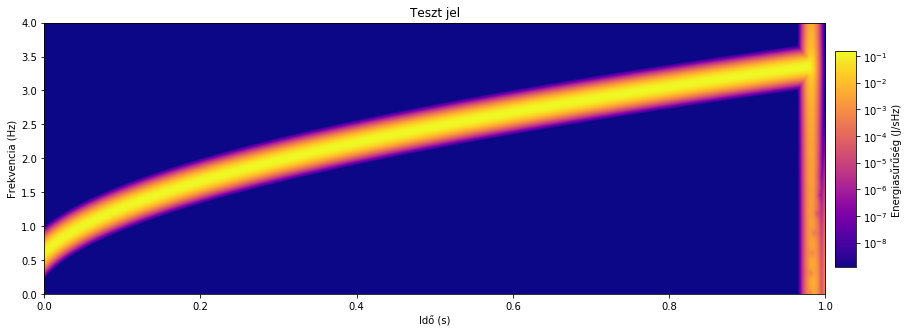

In [363]:
logax = np.linspace(int(np.log10(ch.min())),int(np.log10(ch.max())),int(np.log10(ch.max()))-int(np.log10(ch.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(14,5))
#extent=[0,t-(2*hann_r/s_rate),0,frangemax/t],
#plt.figure(figsize=(15,10))
#ax.plot(np.linspace(min(x),max(x),np.size(ridge)),ridge/1000,'.',color='g',alpha=0.6)#,linewidth=3,linestyle='dashed')#img = ax.
img = plt.imshow(abs(ch),cmap='plasma', interpolation='gaussian', aspect='auto', extent=[0,1,4,0], norm=colors.LogNorm(vmin=ch.min()*1000000, vmax=ch.max()))#
#plt.title('My Short-time Fourier transform')
plt.title('Teszt jel')
plt.ylabel('Frekvencia (Hz)')
plt.xlabel('Idő (s)')#('time (s)')
#plt.xlim(0.652,0.66)
#plt.ylim(90,40)
plt.subplots_adjust(right=0.90)
plt.gca().invert_yaxis()
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Energiasűrűség (J/sHz)')
#plt.axis([0,1.15,min(s),20000])
cbar.set_ticks(logax)
plt.savefig('hffig_1.pdf')
plt.show()

## Tasks
<br> 
<br> Import and evaluate chirps
<br> Reconstruct wave frequencies and amplitudes
<br> Get the radial ?function of several wave types